# TS6: Estimación espectral. Ventaneo de la información.

En esta tarea experimentaremos algunos conceptos presentados en el libro de Holton. DSP Principles and App.

***1) Implemente las funciones para generar las siguientes ventanas $w(k)$:***

Bartlett ó triangular
Hann
Blackman
Flat-top
Ayuda: Puede consultar el capítulo 7.3 del mismo libro para obtener las expresiones analíticas de cada ventana.

+ a) Para cada ventana grafique $w(k)$ y $\lvert W(\Omega)\rvert$, para $N = 1000$ muestras, normalizando $w(k)$ de forma tal que la amplitud máxima de $\lvert W(\Omega)\rvert$ (lóbulo principal) sea 0 dB. 
    + *Ayuda: Posiblemente convenga utilizar zero-padding para visualizar mejor $\lvert W(\Omega)\rvert$.*

+ b) Construya una tabla en la que figuren dos mediciones de la anchura del lóbulo principal de cada ventana:
    + $\Omega_0$ será la frecuencia del primer cruce por cero, es decir $\lvert W(\Omega)\rvert=0$ y 
    + $\Omega_1$, aquella frecuencia tal que $\lvert W(\Omega_1)\rvert=\frac{2}{\sqrt{2}}\vee−3$ dB y el valor de transferencia máxima de los lóbulos secundarios (expresado en dB)
    + $W_2=max${$\lvert W(\Omega)\rvert$},  $\forall\Omega\geq\Omega_0$

Sugerencia: Normalice $\Omega_{0,1}$ por $\vartriangle_f=\frac{f_S}{N}$ para facilitar la comparación.

## Descripción de las ventanas

In [31]:
from pandas import DataFrame
from IPython.display import HTML
df = DataFrame([['','','']],columns=['$\Omega_0$', '$\Omega_1$', '$W_2$' ],
               index=[  
                        'Rectangular',
                        'Bartlett',
                        'Hann',
                        'Blackman',
                        'Flat-top'
                     ])
HTML(df.to_html())

,$\Omega_0$,$\Omega_1$,$W_2$
Rectangular,,,
Bartlett,,,
Hann,,,
Blackman,,,
Flat-top,,,


## Resolucion:

In [43]:
from IPython.display import display, Javascript

def load_ipython_extension():
    disable_js = """
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    """

    display(Javascript(disable_js))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

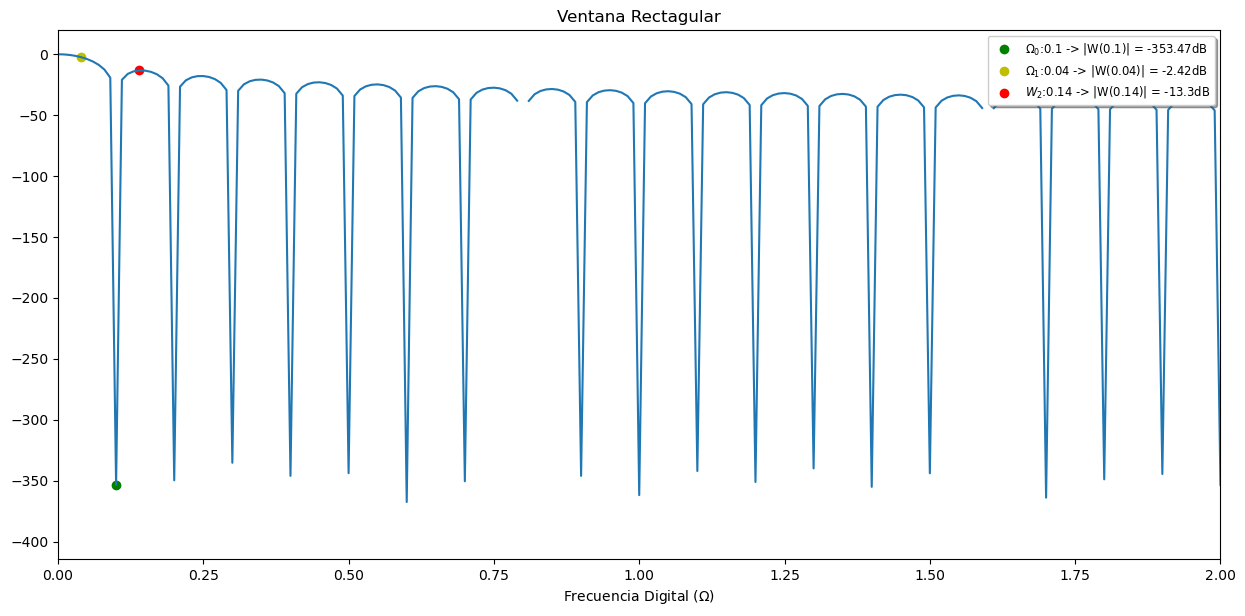

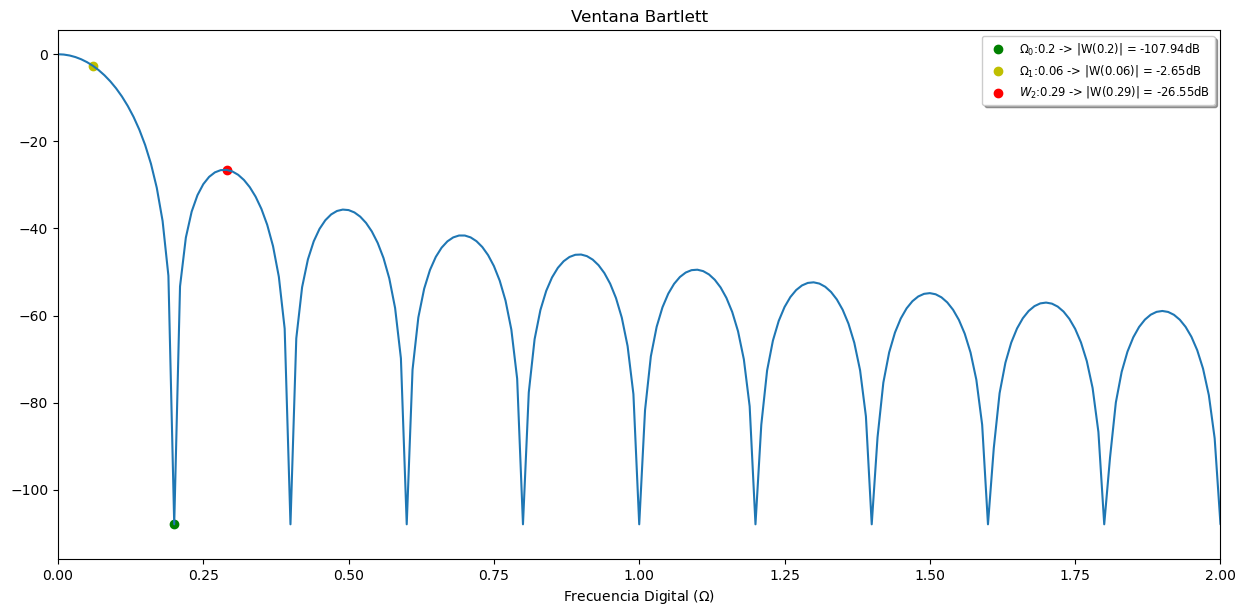

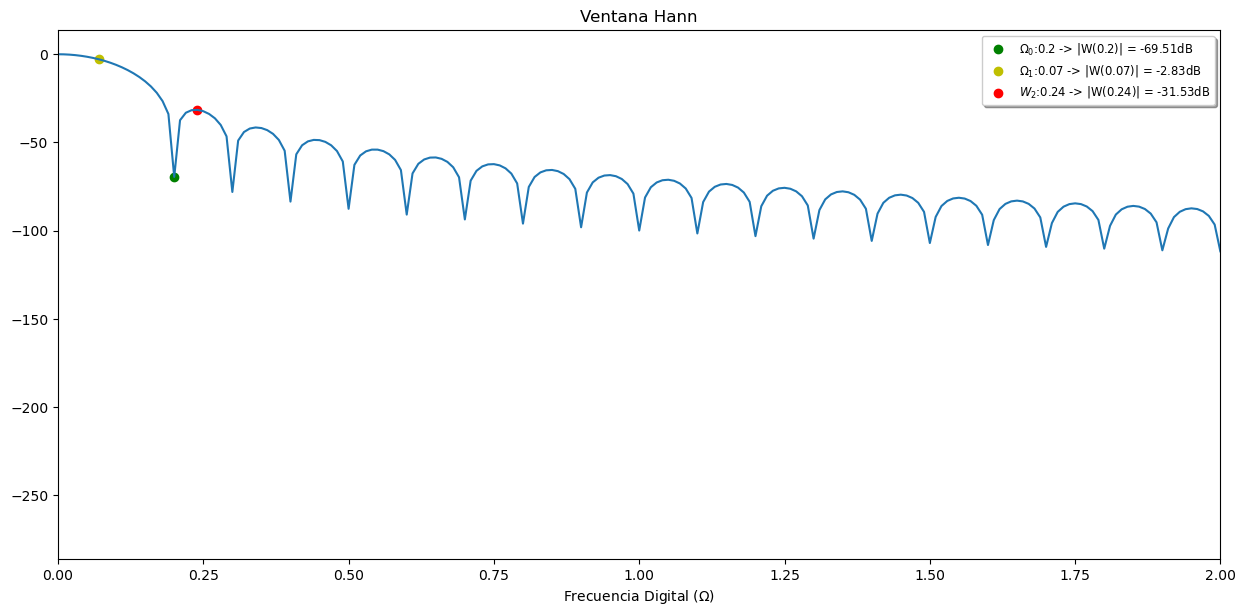

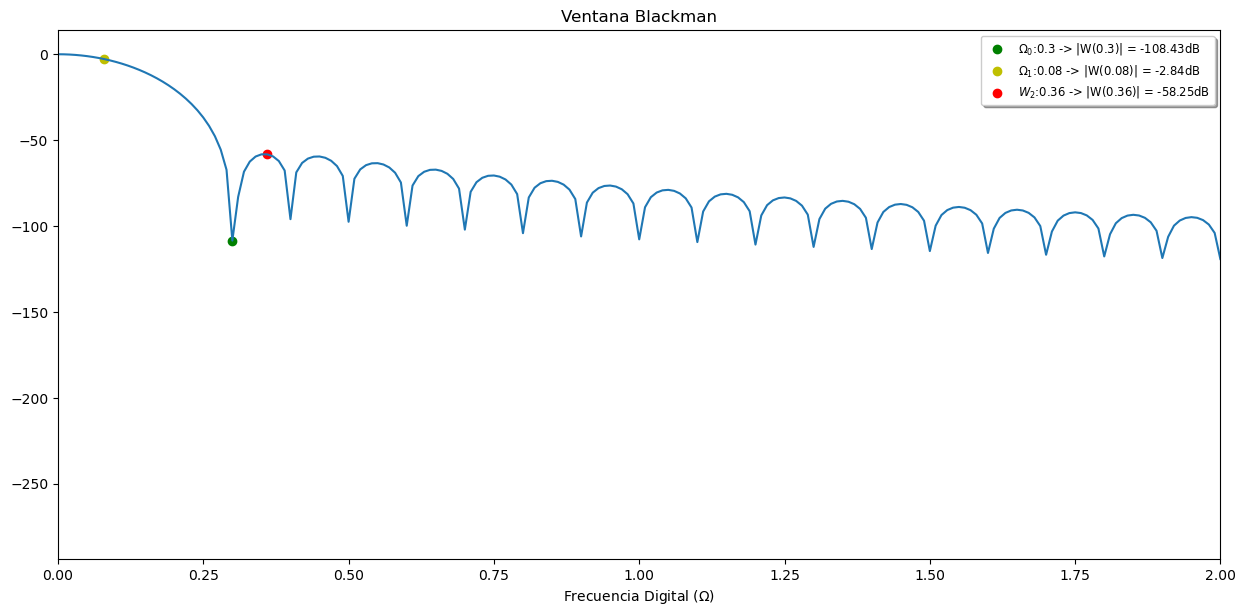

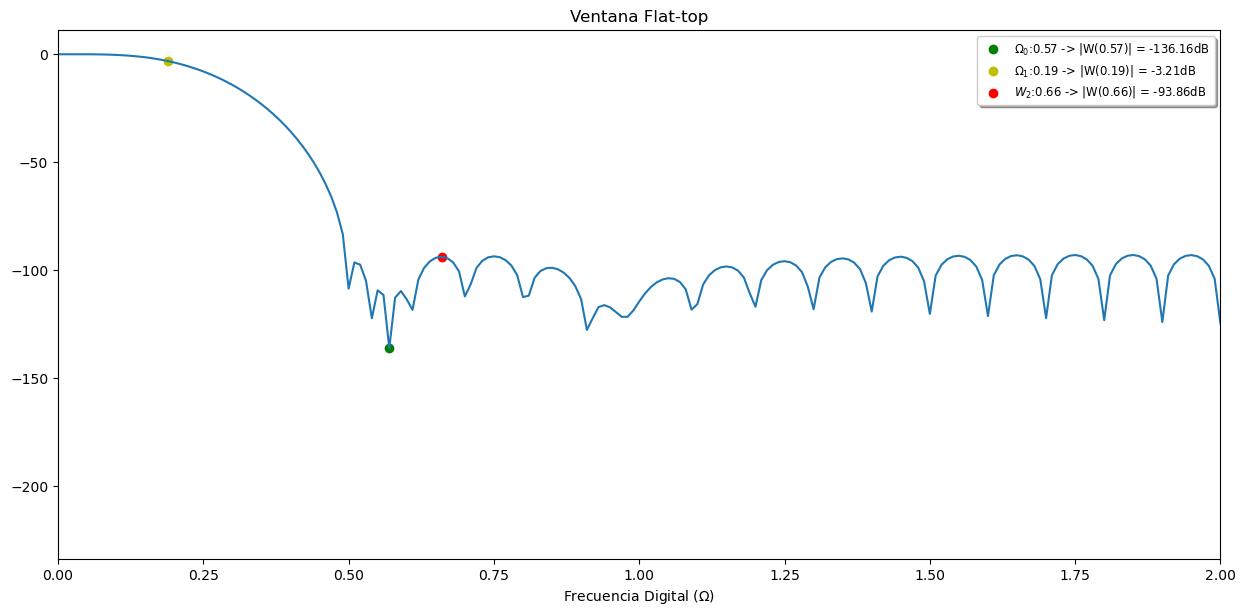

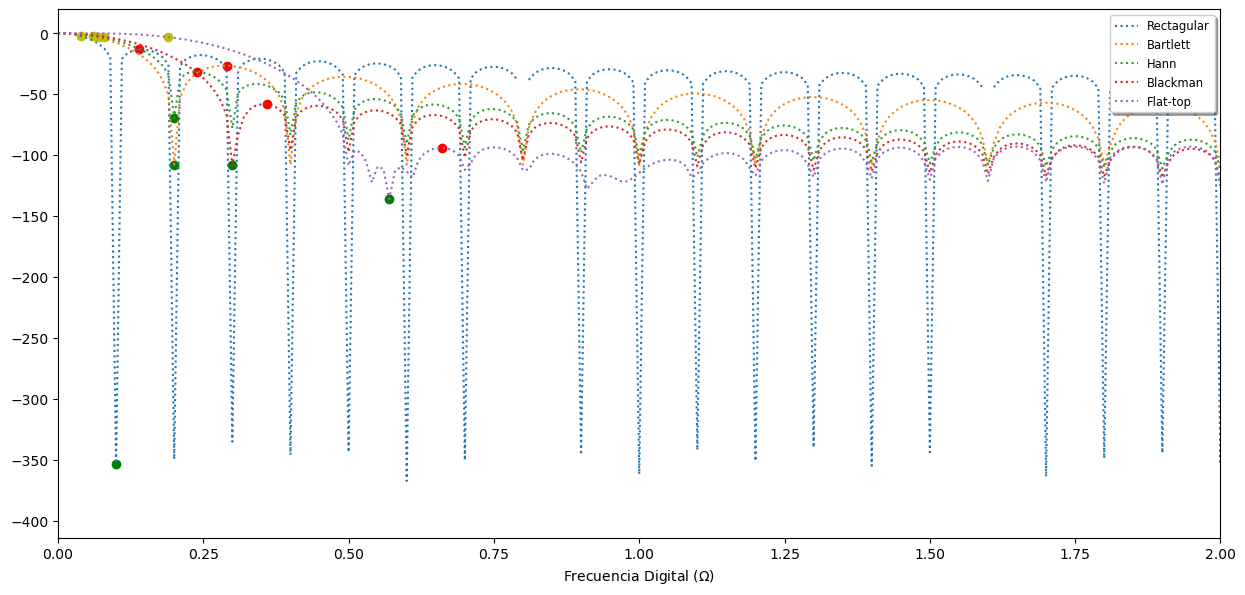

In [44]:


import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sg
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

################# Ventana de Bartlett #################
def w_Bartlett(M):
    N = M - 1
    w = np.linspace(0, N, M)
    
    w[0:N//2] = 2 * w[0:N//2]/N
    w[N//2:] = 2 - (2 * w[N//2:]/N)
    return  w
################# Ventana de Hann #################
def w_Hann(M):
    N = M - 1
    w = np.linspace(0, N, M)
    
    w[0:N+1] = 0.5 - 0.5*np.cos((2*np.pi*w[0:N+1])/N)
    return  w
################# Ventana de Blackman #################
def w_Blackman(M):
    N = M - 1
    w = np.linspace(0, N, M)
    
    w[0:N+1] = 0.42 - 0.5*np.cos((2*np.pi*w[0:N+1])/N) + 0.08*np.cos((4*np.pi*w[0:N+1])/N)
    return  w
################# Primer cruce por cero #################
def first_zero(fftw, step):
    min_backup = fftw[0:step].argmin()
    encontrado = 0
    i = 1
    while(encontrado == 0):
        i += 1
        min_ = fftw[0:step*i].argmin()    
        if min_ == min_backup:
            encontrado = 1
        else:
            min_backup = min_
    return min_
################# Punto amximo del segundo lobulo #################
def second_max(fftw, step, init):
    max_backup = fftw[init:init+step].argmax()
    encontrado = 0
    i = 1
    while(encontrado == 0):
        i += 1
        max_ = fftw[init:init+(step*i)].argmax()    
        if max_ == max_backup:
            encontrado = 1
        else:
            max_backup = max_
    return max_+init
    

N=1000
fs = 1000
Npad = 10 * N
pi=np.pi
step = [1,1,1,1,5]
min_ = []
max_ = []
tus_resultados = []

ventanas = {1:sg.windows.boxcar, 2:w_Bartlett, 3:w_Hann, 4:w_Blackman, 5:sg.flattop}
w_name = {1:'Rectagular', 2:'Bartlett', 3:'Hann', 4:'Blackman', 5:'Flat-top'}
np.seterr(divide = 'ignore')
for i in range(1, 6):

    w = ventanas[i](N)
    
    fftx = np.fft.fft(w, n = Npad) * (1/Npad)
    fftx = fftx / np.abs(fftx[0])
    ff = np.fft.fftfreq(Npad, d=1/fs)*(fs/Npad)
    ff = ff[0:ff.size//2]
    
    fftx_db = 20*np.log10(np.abs(fftx[0:ff.size]))
    
    plt.figure(i, figsize=(15, 7), dpi=100)
    plt.title(f'Ventana {w_name[i]}')
    plt.plot(ff, fftx_db)
    
    min_.append(first_zero(fftx_db, step[i-1]))
    plt.scatter(ff[min_[i-1]], fftx_db[min_[i-1]], color='green', label = f"$\Omega_0$:{round(ff[min_[i-1]],4)} -> |W({round(ff[min_[i-1]],4)})| = {round(fftx_db[min_[i-1]],2)}dB")
    
    p_3db = fftx_db[(fftx_db > -4) & (fftx_db < -2)]
    p_3db = p_3db[np.abs(np.abs(p_3db)-3).argmin()]
    plt.scatter(ff[fftx_db == p_3db][0], p_3db, color='y', label = f"$\Omega_1$:{round(ff[fftx_db == p_3db][0],4)} -> |W({round(ff[fftx_db == p_3db][0],4)})| = {round(p_3db,2)}dB")
    
    max_.append(second_max(fftx_db, step[i-1], min_[i-1]))
    plt.scatter(ff[max_[i-1]], fftx_db[max_[i-1]], color='r', label = f"$W_2$:{round(ff[max_[i-1]],4)} -> |W({round(ff[max_[i-1]],4)})| = {round(fftx_db[max_[i-1]],2)}dB")
    
    plt.xlim(0,2)
    plt.xlabel("Frecuencia Digital ($\Omega$)")
    plt.legend(loc='upper right', shadow=True, fontsize='small')
    
    plt.figure(6, figsize=(15, 7), dpi=100)
    plt.plot(ff, fftx_db, ':', label = f"{w_name[i]}")
    plt.scatter(ff[min_[i-1]], fftx_db[min_[i-1]], color='green')
    plt.scatter(ff[fftx_db == p_3db][0], p_3db, color='y')
    plt.scatter(ff[max_[i-1]], fftx_db[max_[i-1]], color='r')

    plt.xlim(0,2)
    plt.xlabel("Frecuencia Digital ($\Omega$)")
    plt.legend(loc='upper right', shadow=True, fontsize='small')
    
    tus_resultados.append([f'{round(ff[min_[i-1]],4)}', f'{round(ff[fftx_db == p_3db][0],4)}', f'{round(ff[max_[i-1]],4)}'])
    

df = DataFrame(tus_resultados, columns=['$\Omega_0$', '$\Omega_1$', '$W_2$' ],
               index=[  
                        'Rectangular',
                        'Bartlett',
                        'Hann',
                        'Blackman',
                        'Flat-top'
                     ])
HTML(df.to_html())

load_ipython_extension()